In [1]:
using Agents
#using Random: Xoshiro # access the RNG object

In [2]:
using Random: Xoshiro # access the RNG object

In [3]:
rng = Xoshiro(1234)

Xoshiro(0x9951797c85a704f1, 0xb9d66be14dfba82b, 0xb170153285fd9556, 0xe90a07f7bdd1fd77, 0x9d4b5ee33e4bd661)

In [17]:
#参数设置
L = 4 #初始矩阵大小，对应L*L矩阵
betray=2
b = 1.2
payMtx=[1 0; b 0]
alpha =  0.3 
theta = 20 
Kmax = 1 
lamda = 10 #额外阈值


10

In [1]:
L = 4 #初始矩阵大小，对应L*L矩阵
betray=2
b = 1.2

1.2

In [3]:
L = 100; #初始矩阵大小，对应L*L矩阵
theta = 10;
alpha = 0.3;

In [5]:
T = 10  #迭代次数

10

In [6]:
size = (L, L)

(4, 4)

In [7]:
space = GridSpaceSingle(size; periodic = true, metric = :manhattan)

GridSpaceSingle with size (4, 4), metric=manhattan, periodic=true

In [9]:
@agent struct SchellingAgent(GridAgent{2})
    #mood::Bool # whether the agent is happy in its position
    #group::Int # The group of the agent, determines mood as it interacts with neighbors
    A_self::Int   #伦理
    A_peer::Int   #收益
    #A_mtx::Float64  #压力
    revenue::Float64  #收益
    #revenue_nb_av::Float64  #邻居的平均收益
    #P1::Float64   #第一层概率
    #P2::Float64   #第二层概率
    #Pmix::Float64  #概率相乘
    strate::Int   #1-合作 0-背叛
end

In [18]:
properties = Dict(:min_betray => betray, :payMtx => payMtx,
:alpha => alpha, :theta => theta,  :lamda => lamda, :Kmax => Kmax)

Dict{Symbol, Any} with 6 entries:
  :alpha      => 0.3
  :min_betray => 2
  :Kmax       => 1
  :payMtx     => [1.0 0.0; 1.2 0.0]
  :lamda      => 10
  :theta      => 20

In [20]:
function schelling_step_1!(agent, model)
    # Here we access a model-level property `min_to_be_happy`.
    # This will have an assigned value once we create the model.
    A = model.payMtx    
    #以下是针对当前单个代理的指令
    payoff=0
    a=[agent.strate, 1-agent.strate]
    PA=transpose(a) * A
    # For each neighbor, get group and compare to current agent's group
    # and increment `count_neighbors_same_group` as appropriately.
    # Here `nearby_agents` (with default arguments) will provide an iterator
    # over the nearby agents one grid cell away, which are at most 8.
    for neighbor in nearby_agents(agent, model)
        b=[neighbor.strate, 1-neighbor.strate]
        payoff += PA * b
    end
    agent.revenue=payoff
    return
end

schelling_step_1! (generic function with 1 method)

In [29]:
function schelling_step_2!(agent, model)
    # Here we access a model-level property `min_to_be_happy`.
    # This will have an assigned value once we create the model.
    minbetray = model.min_betray
    alpha = model.alpha
    theta = model.theta
    lamda = model.lamda
    Kmax = model.Kmax
    #以下是针对当前单个代理的指令
    count_betray = 0
    revenue_nb = 0
    # For each neighbor, get group and compare to current agent's group
    # and increment `count_neighbors_same_group` as appropriately.
    # Here `nearby_agents` (with default arguments) will provide an iterator
    # over the nearby agents one grid cell away, which are at most 8.
    for neighbor in nearby_agents(agent, model)
        if neighbor.strate==0
            count_betray += 1
        end
        revenue_nb += neighbor.revenue
    end
    #nearby_number = length(nearby_agents(agent, model))
    nearby_number = 4
    revenue_nb_av=revenue_nb/nearby_number
    #更新压力矩阵A
    agent.A_self += (count_betray>=2)
    agent.A_peer += (agent.revenue <= revenue_nb_av) #计算朋辈压力
    A_mtx = (1-alpha) * agent.A_self + alpha * agent.A_peer #更新压力矩阵A
    #迭代&策略更新
    A_gap=maximum([theta-A_mtx,0])
    P1 = exp(-A_gap)  #计算概率P1
    ragent = random_agent(model)
    K_A = Kmax*A_gap/theta 
    drevenue= agent.revenue -ragent.revenue
    P2 = 1 / (1+ exp(drevenue/K_A))
    isnan(P2) && (P2= 0) #处理NaN值赋0  #0/0先赋值为0，然后赋值为0.5
    Pmix=P1*P2
    if Pmix > rand() 
        agent.strate = ragent.strate
        agent.A_peer = 0 #清空改变策略的Ap
        agent.A_self = 0 #清空改变策略的As
    end
    #Fc(t+1) = sum(sum(Strmtx))/L^2  #在最后提取数据时计算
    #overstress(t+1) = sum(sum(A_mtx >= (theta+H)))/L^2  #在最后提取数据时计算
    return
end

schelling_step_2! (generic function with 1 method)

In [30]:
function complex_model_step!(model)
    # tip: these schedulers should be defined as properties of the model
    for agent in allagents(model)
        schelling_step_1!(agent, model)
        schelling_step_2!(agent, model)
    end
    return
end

complex_model_step! (generic function with 1 method)

In [31]:
schelling = StandardABM(
    # input arguments
    SchellingAgent, space;
    # keyword arguments
    properties, # in Julia if the input variable and keyword are named the same,
                # you don't need to repeat the keyword!
    model_step! = complex_model_step!
)

StandardABM with 0 agents of type SchellingAgent
 agents container: Dict
 space: GridSpaceSingle with size (4, 4), metric=manhattan, periodic=true
 scheduler: fastest
 properties: alpha, min_betray, Kmax, payMtx, lamda, theta

In [11]:
scheduler = Schedulers.ByProperty(:group)

Agents.Schedulers.ByProperty{Symbol}(:group, Int64[], Int64[])

In [12]:
using Random: Xoshiro # access the RNG object

schelling = StandardABM(
    SchellingAgent,
    space;
    properties,
    agent_step! = schelling_step!,
    scheduler,
    rng = Xoshiro(1234) # input number is the seed
)

StandardABM with 0 agents of type SchellingAgent
 agents container: Dict
 space: GridSpaceSingle with size (10, 10), metric=chebyshev, periodic=false
 scheduler: Agents.Schedulers.ByProperty{Symbol}
 properties: min_to_be_happy

In [13]:
function initialize(; total_agents = 320, gridsize = (20, 20), min_to_be_happy = 3, seed = 125)
    space = GridSpaceSingle(gridsize; periodic = false)
    properties = Dict(:min_to_be_happy => min_to_be_happy)
    rng = Xoshiro(seed)
    model = StandardABM(
        SchellingAgent, space;
        agent_step! = schelling_step!, properties, rng,
        container = Vector, # agents are not removed, so we us this
        scheduler = Schedulers.Randomly() # all agents are activated once at random
    )
    # populate the model with agents, adding equal amount of the two types of agents
    # at random positions in the model. At the start all agents are unhappy.
    for n in 1:total_agents
        add_agent_single!(model; mood = false, group = n < total_agents / 2 ? 1 : 2)
    end
    return model
end

schelling = initialize()

StandardABM with 320 agents of type SchellingAgent
 agents container: Vector
 space: GridSpaceSingle with size (20, 20), metric=chebyshev, periodic=false
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

In [1]:
total_agents = L^2

UndefVarError: UndefVarError: `L` not defined

In [32]:
for n in 1:total_agents
    add_agent_single!(schelling; revenue=0, A_self=0, A_peer=0, strate = rand(0:1))
end

In [28]:
step!(schelling, 3)

MethodError: MethodError: no method matching length(::Base.Iterators.Filter{Agents.var"#167#173"{Matrix{Int64}}, Base.Generator{Vector{Tuple{Int64, Int64}}, Agents.var"#164#170"{Tuple{Int64, Int64}}}})

Closest candidates are:
  length(!Matched::Base.AsyncGenerator)
   @ Base asyncmap.jl:390
  length(!Matched::HTTP.Forms.Form)
   @ HTTP C:\Users\xingfu_2\.julia\packages\HTTP\vnQzp\src\multipart.jl:20
  length(!Matched::RegexMatch)
   @ Base regex.jl:285
  ...


In [14]:
happy90(model, time) = count(a -> a.mood == true, allagents(model))/nagents(model) ≥ 0.9

step!(schelling, happy90)

StandardABM with 320 agents of type SchellingAgent
 agents container: Vector
 space: GridSpaceSingle with size (20, 20), metric=chebyshev, periodic=false
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

In [15]:
abmtime(schelling)

6

In [10]:
using CairoMakie

In [16]:
groupcolor(a) = a.group == 1 ? :blue : :orange
groupmarker(a) = a.group == 1 ? :circle : :rect

groupmarker (generic function with 1 method)

In [17]:
figure, _ = abmplot(model; agent_color = groupcolor, agent_marker = groupmarker, as = 10)
figure # returning the figure displays it

UndefVarError: UndefVarError: `model` not defined

┌ Warning: Keywords `as, am, ac` has been deprecated in favor of
│           `agent_size, agent_marker, agent_color`
└ @ AgentsVisualizations C:\Users\xingfu_2\.julia\packages\Agents\NZmFl\ext\AgentsVisualizations\src\abmplot.jl:70


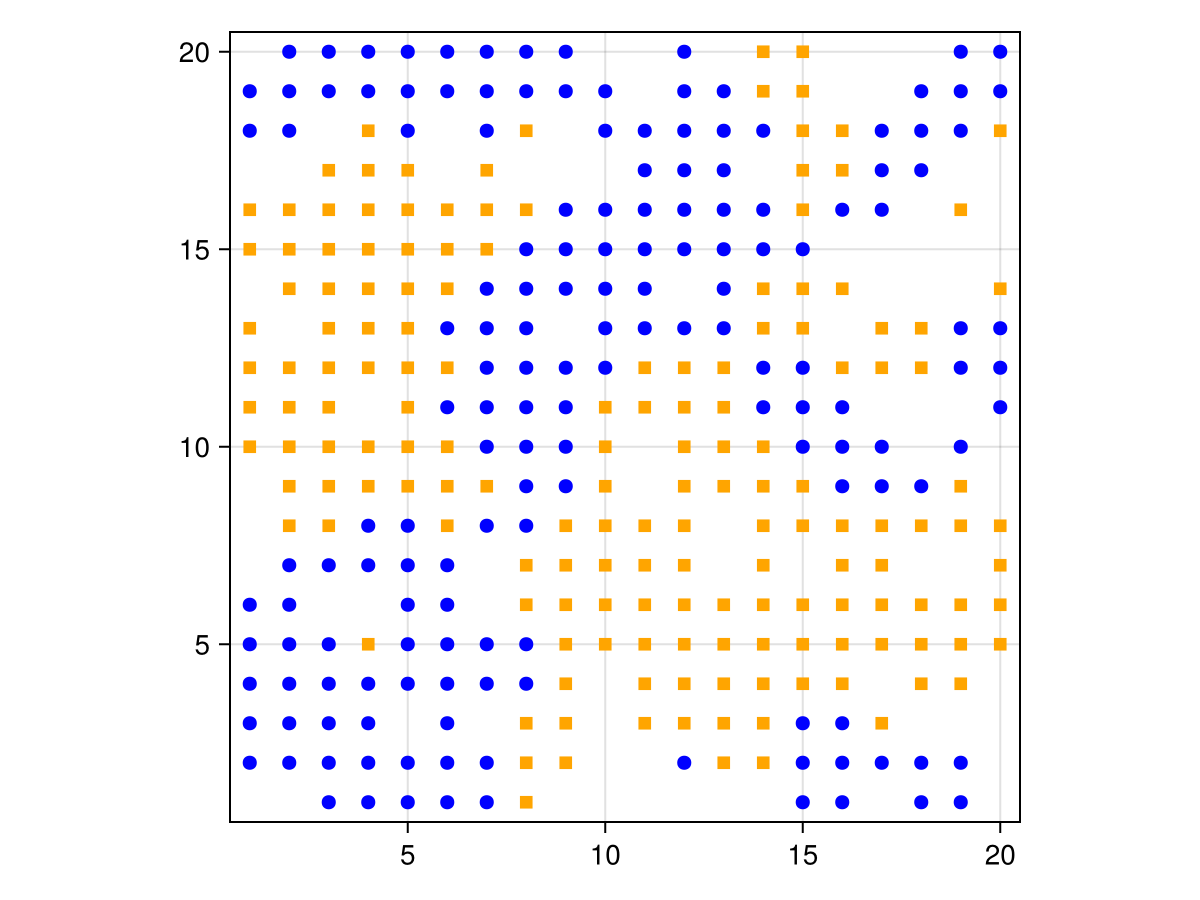

In [18]:
figure, _ = abmplot(schelling; agent_color = groupcolor, agent_marker = groupmarker, as = 10)
figure # returning the figure displays it

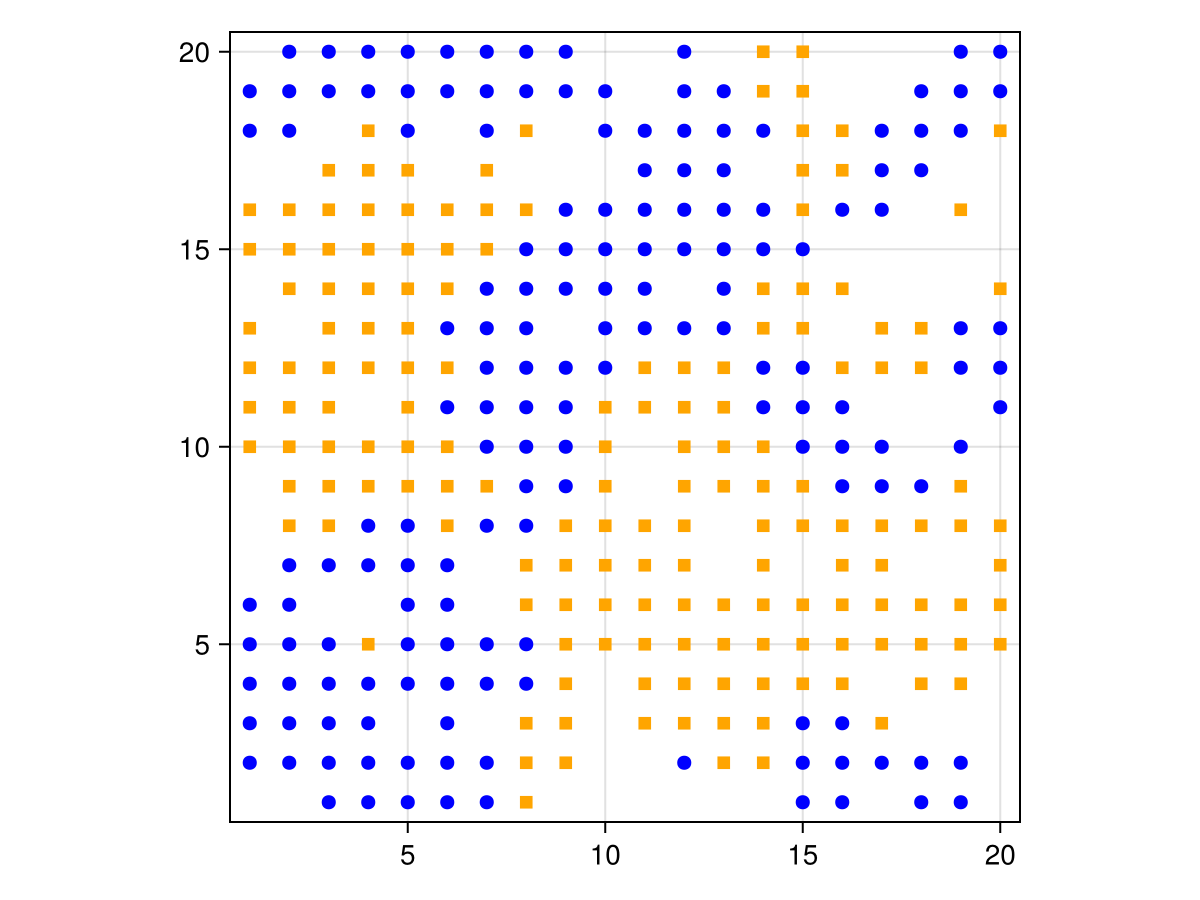

In [19]:
figure, _ = abmplot(schelling; agent_color = groupcolor, agent_marker = groupmarker, agent_size = 10)
figure # returning the figure displays it

In [20]:
schelling = initialize()
abmvideo(
    "schelling.mp4", schelling;
    agent_color = groupcolor, agent_marker = groupmarker, agent_size = 10,
    framerate = 4, frames = 20,
    title = "Schelling's segregation model"
)